In [1]:
import pyabc
import fitmulticell as fmc
import scipy as sp
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (15,5)

ERROR:External:Install rpy2 to enable simple support for the R language.


## __Set these before proceeding__ (You will probably need to change these)

In [2]:
CELL_POLARITY_XML           = "/Users/Synchon/Developer/git-repositories/fitmulticell-pipeline/models/CellPolarity.xml"
MORPHEUS_BIN                = "/Applications/Morpheus.app/Contents/MacOS/bin/morpheus"
CELL_POLARITY_DB            = "sqlite:///../db/cell_polarity/cell_polarity.db"
CELL_POLARITY_STOCHASTIC_DB = "sqlite:///../db/cell_polarity/cell_polarity_stochastic.db"

### Parameter mappings and FMC model initialization

In [3]:
# Create parameter mapping
par_map = {
    "r_a": "./CellTypes/CellType[@name='Cell']/System/Constant[@symbol='r_a']",
    "strength": "./CellTypes/CellType[@name='Cell']/DirectedMotion[@strength]"
}

# Create model instance
model = fmc.model.MorpheusModel(
    model_file=CELL_POLARITY_XML,
    par_map=par_map,
    executable=MORPHEUS_BIN,
    show_stdout=True,
    show_stderr=True,
    raise_on_error=False
)

### True parameters

In [4]:
# True parameters
true_pars = {
    "r_a": 0.02,
    "strength": 0.5
}
# Bounds for true parameters
true_pars_limits = {
    "r_a": (0.5 * 0.02, 2.0 * 0.02),
    "strength": (0.5 * 0.5, 2.0 * 0.5)
}

### Sample data using true parameters

In [5]:
# Generate dummy observed data sampled from true parameters
observed_data = model.sample(true_pars)

### Simulation plot

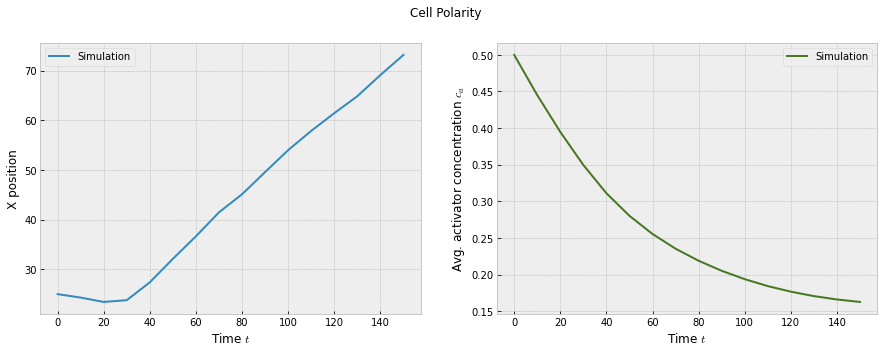

In [6]:
plt.subplot(1,2,1)
plt.plot(
    observed_data["IdSumstat__t"],
    observed_data["IdSumstat__center_cell1"],
    color="C0",
    label="Simulation"
)
plt.xlabel("Time $t$")
plt.ylabel("X position")
plt.legend()

plt.subplot(1,2,2)
plt.plot(
    observed_data["IdSumstat__t"],
    observed_data["IdSumstat__mean_c_a"],
    color="C3",
    label="Simulation",
)
plt.xlabel("Time $t$")
plt.ylabel("Avg. activator concentration $c_a$")

plt.legend()
plt.suptitle("Cell Polarity")

plt.show()

### Sumstat and distance functions

In [7]:
def sumstat(data):
    # Take the last position from the x position array
    return {'x_pos': data['IdSumstat__center_cell1'][-1]}

def dist(data, simulation):
    # Calculate the distance between the x positions
    return np.absolute(data["x_pos"] - simulation["x_pos"])

### Parameter inference (using uniform acceptor)

In [8]:
# Set prior for parameters
priors = pyabc.Distribution(
    **{key: pyabc.RV("uniform", lb, ub - lb) for key, (lb, ub) in true_pars_limits.items()}
)
# Obtain ABCSMC instance
abc_uniform = pyabc.ABCSMC(
    models=model,
    parameter_priors=priors,
    distance_function=dist,
    summary_statistics=sumstat,
    population_size=300,
    sampler=pyabc.sampler.RedisEvalParallelSampler(host="127.0.0.1", port=6379)
)
# Initiate / Load database table
# abc_uniform.new(CELL_POLARITY_DB, {'x_pos': 80}) # x position: 100 is the end of the domain
abc_uniform.load(CELL_POLARITY_DB, 4)

In [22]:
history_uniform = abc_uniform.run(minimum_epsilon=0.2, max_nr_populations=0)

INFO:Epsilon:initial epsilon is 0.636363639999999
INFO:History:Done <ABCSMC(id=4, start_time=2020-11-02 17:09:08.068368, end_time=2020-11-03 20:29:58.432846)>


### Epsilon vs. Population (for uniform acceptor)

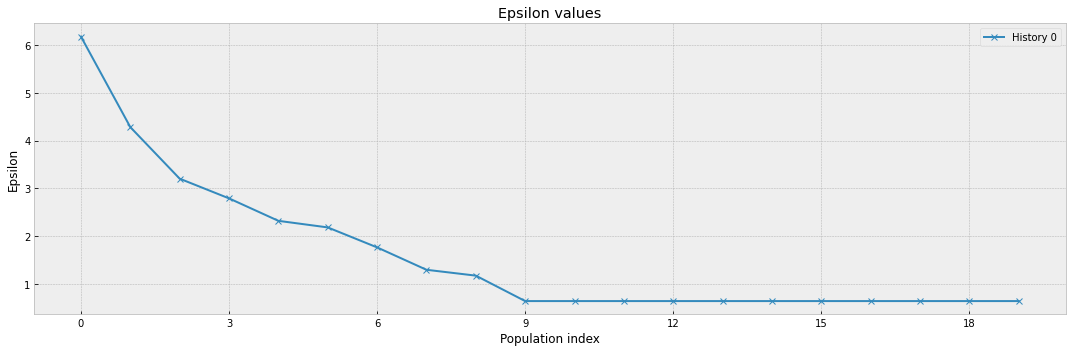

In [9]:
pyabc.visualization.plot_epsilons(abc_uniform.history)
plt.show()

### KDE Matrix (for uniform acceptor)

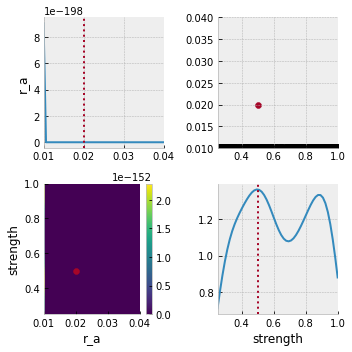

In [11]:
pyabc.visualization.plot_kde_matrix_highlevel(
    abc_uniform.history,
#     t=9,
    limits=true_pars_limits,
    refval=true_pars
)
plt.show()

### Posterior distribution development (for uniform acceptor)

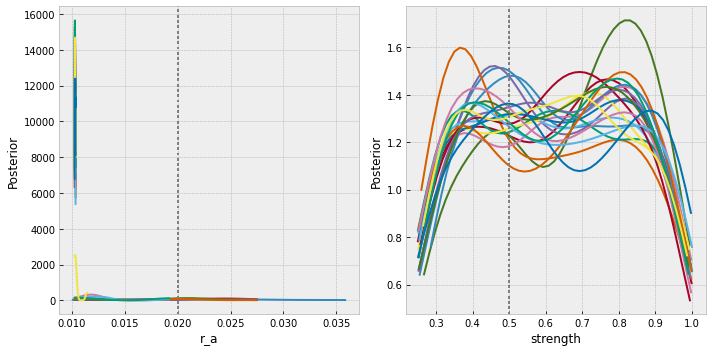

In [13]:
fig, ax = plt.subplots(1,2)

for t in range(abc_uniform.history.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        abc_uniform.history,
        x="r_a",
        t=t,
        refval=true_pars,
        refval_color='grey',
        ax=ax[0],
        label=f"Iteration {t}"
    )
    pyabc.visualization.plot_kde_1d_highlevel(
        abc_uniform.history,
        x="strength",
        t=t,
        refval=true_pars,
        refval_color='grey',
        ax=ax[1],
        label=f"Iteration {t}"
    )

fig.set_size_inches((10, 5))
fig.tight_layout()
plt.show()

### 2D KDE (for uniform acceptor)

/Users/Synchon/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


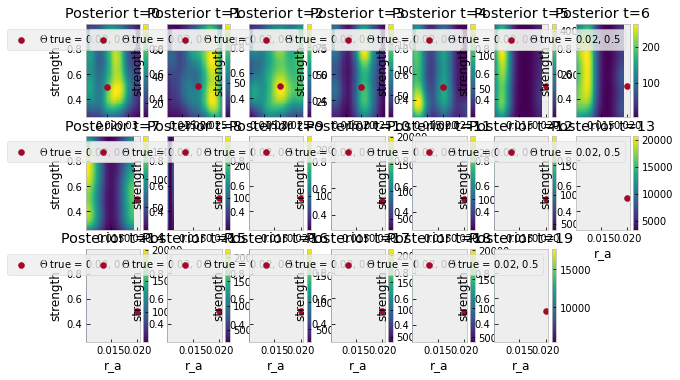

In [23]:
fig = plt.figure(figsize=(10,10))

for t in range(abc_uniform.history.max_t+1):
    ax = fig.add_subplot(5, np.ceil(abc_uniform.history.max_t / 3), t+1)

    ax = pyabc.visualization.plot_kde_2d_highlevel(
        abc_uniform.history,
        x="r_a",
        y="strength",
        t=t,
        ax=ax
    )
    ax.scatter(
        [true_pars["r_a"]],
        [true_pars["strength"]],
        color="C1",
        label=f"$\Theta$ true = {true_pars['r_a']}, {true_pars['strength']}"
    )
    ax.set_title(f"Posterior t={t}")

    ax.legend()

fig.tight_layout()

### Parameter inference (using stochastic acceptor)

In [17]:
# Set prior for parameters
priors = pyabc.Distribution(
    **{key: pyabc.RV("uniform", lb, ub - lb) for key, (lb, ub) in true_pars_limits.items()}
)
# Obtain ABCSMC instance
abc_stochastic = pyabc.ABCSMC(
    models=model,
    parameter_priors=priors,
    summary_statistics=sumstat,
    population_size=300,
    sampler=pyabc.sampler.RedisEvalParallelSampler(host="127.0.0.1", port=6379),
    distance_function=pyabc.IndependentNormalKernel(keys=["x_pos"], var=0.5**2),
    eps=pyabc.Temperature(),
    acceptor=pyabc.StochasticAcceptor()
)
# abc_stochastic.new(CELL_POLARITY_STOCHASTIC_DB, {'x_pos': 80}) # x position: 100 is the end of the domain
abc_stochastic.load(CELL_POLARITY_STOCHASTIC_DB, 2)

In [10]:
history_stochastic = abc_stochastic.run(minimum_epsilon=0.2, max_nr_populations=20)

INFO:ABC:Calibration sample before t=0.
INFO:ABC:t: 0, eps: 48.69651584015426.
INFO:ABC:Acceptance rate: 300 / 1108 = 2.7076e-01, ESS=3.0000e+02.
INFO:ABC:t: 1, eps: 37.51040455854009.
INFO:ABC:Acceptance rate: 300 / 964 = 3.1120e-01, ESS=2.4345e+02.
INFO:ABC:t: 2, eps: 30.668947582651523.
INFO:ABC:Acceptance rate: 300 / 1185 = 2.5316e-01, ESS=1.2651e+02.
INFO:ABC:t: 3, eps: 25.07529195958196.
INFO:ABC:Acceptance rate: 300 / 1619 = 1.8530e-01, ESS=2.5358e+02.
INFO:ABC:t: 4, eps: 20.501853386516323.
INFO:ABC:Acceptance rate: 300 / 2077 = 1.4444e-01, ESS=2.6107e+02.
INFO:ABC:t: 5, eps: 16.76255626294284.
INFO:ABC:Acceptance rate: 300 / 2348 = 1.2777e-01, ESS=2.3965e+02.
INFO:ABC:t: 6, eps: 13.705262991155795.
INFO:ABC:Acceptance rate: 300 / 2914 = 1.0295e-01, ESS=1.8933e+02.
INFO:ABC:t: 7, eps: 11.205584083377056.
INFO:ABC:Acceptance rate: 300 / 3974 = 7.5491e-02, ESS=2.7371e+02.
INFO:ABC:t: 8, eps: 9.161817232596134.
INFO:ABC:Acceptance rate: 300 / 4792 = 6.2604e-02, ESS=2.6192e+02.
INF

### Epsilon vs. Population (for stochastic acceptor)

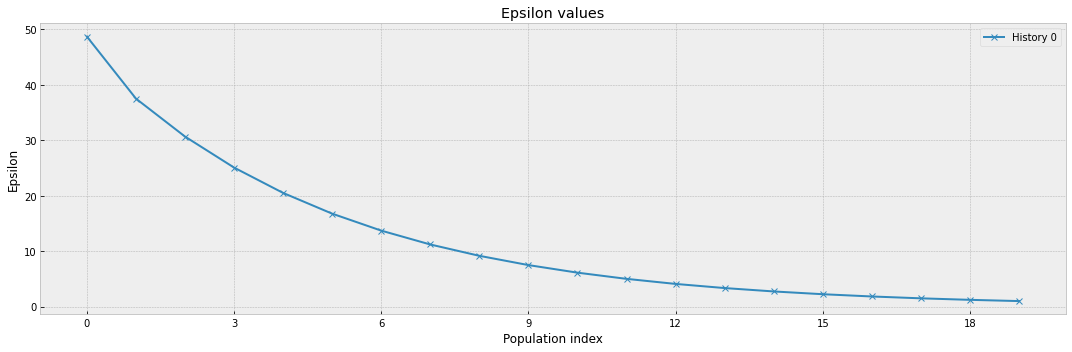

In [18]:
pyabc.visualization.plot_epsilons(abc_stochastic.history)
plt.show()

### KDE Matrix (for stochastic acceptor)

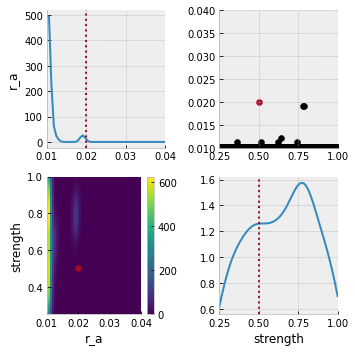

In [19]:
pyabc.visualization.plot_kde_matrix_highlevel(
    abc_stochastic.history,
    limits=true_pars_limits,
    refval=true_pars
)
plt.show()

### Posterior distribution development (for stochastic acceptor)

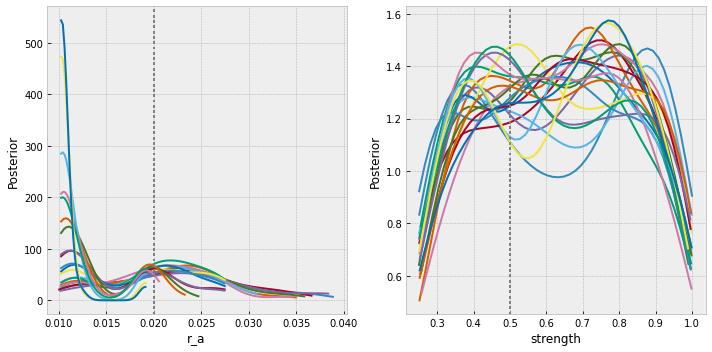

In [20]:
fig, ax = plt.subplots(1,2)

for t in range(abc_stochastic.history.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        abc_stochastic.history,
        x="r_a",
        t=t,
        refval=true_pars,
        refval_color='grey',
        ax=ax[0],
        label=f"Iteration {t}"
    )
    pyabc.visualization.plot_kde_1d_highlevel(
        abc_stochastic.history,
        x="strength",
        t=t,
        refval=true_pars,
        refval_color='grey',
        ax=ax[1],
        label=f"Iteration {t}"
    )

fig.set_size_inches((10, 5))
fig.tight_layout()
plt.show()

### 2D KDE (for stochastic acceptor)

/Users/Synchon/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


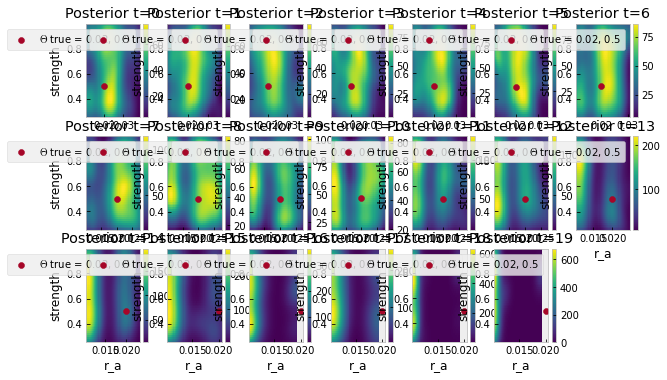

In [22]:
fig = plt.figure(figsize=(10,10))

for t in range(abc_stochastic.history.max_t+1):
    ax = fig.add_subplot(5, np.ceil(abc_stochastic.history.max_t / 3), t+1)

    ax = pyabc.visualization.plot_kde_2d_highlevel(
        abc_stochastic.history,
        x="r_a",
        y="strength",
        t=t,
        ax=ax
    )
    ax.scatter(
        [true_pars["r_a"]],
        [true_pars["strength"]],
        color="C1",
        label=f"$\Theta$ true = {true_pars['r_a']}, {true_pars['strength']}"
    )
    ax.set_title("Posterior t={}".format(t))

    ax.legend()

fig.tight_layout()